In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import healpy as hp
from rubin_sim.utils import healbin
import pandas as pd
from rubin_sim.scheduler.utils import empty_observation
from astropy import units
from astropy.coordinates import Angle
from pointing_survey import PointingsSurvey
from rubin_sim.scheduler.schedulers import Core_scheduler
from rubin_sim.scheduler import sim_runner
from rubin_sim.scheduler.modelObservatory import Model_observatory

from rubin_sim.scheduler.surveys import BaseSurvey
from rubin_sim.scheduler.utils import empty_observation

import pickle

In [2]:
tiles = pd.read_csv('/Users/yoachim/git_repos/ts_fbs_utils/python/lsst/ts/fbs/utils/data/auxtel_tiles.txt', delimiter=' ')

In [3]:
tiles

,Survey,Name,RA,Dec
0,LATISS_POLE,001,00:00:00.00,-89:53:48.23
1,LATISS_POLE,002,02:10:54.54,-89:53:48.23
2,LATISS_POLE,003,04:21:49.09,-89:53:48.23
3,LATISS_POLE,004,06:32:43.63,-89:53:48.23
4,LATISS_POLE,005,08:43:38.18,-89:53:48.23
...,...,...,...,...
1626,AUXTEL_DRP_IMAGING,A2390_060,21:53:13.25,+17:58:37.05
1627,AUXTEL_DRP_IMAGING,A2390_061,21:53:36.96,+17:58:37.05
1628,AUXTEL_DRP_IMAGING,A2390_062,21:54:00.67,+17:58:37.05
1629,AUXTEL_DRP_IMAGING,A2390_063,21:54:24.38,+17:58:37.05


In [4]:

class SCP_survey(BaseSurvey):
    """A South Celestial Pole survey"""
    def generate_observations_rough(self, conditions):
        obs = empty_observation()
        obs['RA'] = 0.
        obs['dec'] = np.radians(-87.)
        obs['exptime'] = 30.  # Seconds
        obs['nexp'] = 2
        obs['filter'] = 'r'
        # If it's been 12 hours or more, don't try to execute the observation anymore
        obs['flush_by_mjd'] = conditions.mjd + 0.5
        obs['note'] = 'scp'  # Always good to set the note to which survey generated the observation
        # Make it a list of 3
        result = [obs] * 3
        return result

In [5]:
obs = empty_observation()
obs = np.zeros(tiles['Survey'].size, dtype=obs.dtype)

In [6]:
obs.dtype

dtype([('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('filter', '<U1'), ('rotSkyPos', '<f8'), ('rotSkyPos_desired', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), ('sunAlt', '<f8'), ('note', '<U40'), ('field_id', '<i8'), ('survey_id', '<i8'), ('block_id', '<i8'), ('lmst', '<f8'), ('rotTelPos', '<f8'), ('rotTelPos_backup', '<f8'), ('moonAz', '<f8'), ('sunAz', '<f8'), ('sunRA', '<f8'), ('sunDec', '<f8'), ('moonRA', '<f8'), ('moonDec', '<f8'), ('moonDist', '<f8'), ('solarElong', '<f8'), ('moonPhase', '<f8'), ('cummTelAz', '<f8'), ('scripted_id', '<i8')])

In [7]:
obs['note'] = tiles['Survey'] + tiles['Name']
obs['RA'] = Angle(tiles['RA'],unit=units.hourangle).rad
obs['dec'] = Angle(tiles['Dec'],unit=units.degree).rad

obs['flush_by_mjd'] = 0.
obs['nexp'] = 1
obs['filter'] = 'r'
obs['exptime'] = 60.
# obs['rotSkyPos'] = np.nan

In [8]:
ps = PointingsSurvey(obs)
scp = SCP_survey([])
sched = Core_scheduler([[ps]])

In [9]:
mo = Model_observatory()

In [10]:
conditions = mo.return_conditions()
ack = ps.generate_observations(conditions)
ack

/Users/yoachim/git_repos/22_Scratch/auxTel_test/pointing_survey.py:141: RuntimeWarning: invalid value encountered in true_divide
  result = np.floor(1.+self.n_obs/sum_obs)


[array([(0, 5.39245725, -0.08614068, 0., 0., 60., 'r', 0., 0., 1, 0., 0., 0., 0., 0., 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 'AUXTEL_DRP_IMAGINGSDSS-J203722_057', 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0)],
       dtype=[('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('filter', '<U1'), ('rotSkyPos', '<f8'), ('rotSkyPos_desired', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), ('sunAlt', '<f8'), ('note', '<U40'), ('field_id', '<i8'), ('survey_id', '<i8'), ('block_id', '<i8'), ('lmst', '<f8'), ('rotTelPos', '<f8'), ('rotTelPos_backup', '<f8'), ('moonAz', '<f8'), ('sunAz', '<f8'), ('sunRA', '<f8'), ('sunDec', '<f8'), ('moonR

In [11]:
mo, sched, completed_obs = sim_runner(mo, sched, survey_length=3)


progress = 99.49%

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:272: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1249 observations
ran in 0 min = 0.0 hours
Writing results to  None


In [12]:
completed_obs

array([(1229, 5.39245725, -0.08614068, 60220.98525399, 0., 60., 'r', 2.72123273, 0., 1, 1.13313528, 0.31293321, 0.62284008, 0.56397455, 20.23952488, 3, 54.71709396, 61., 0.4366023 , 24.6367926 , 1.08116681, 0.49001237, 3.56195258, 0., -0.83834562, -0.21307789, 'AUXTEL_DRP_IMAGINGSDSS-J203722_057', 0, 0, 0, 19.75716679, 0., 0., 1.46219606, 4.49889752, 3.3046998 , -0.07026651, 1.1934235 , 0.45107402, 2.06900037, 2.07733405, 66.39335683, 0.49001237, 0),
       (1230, 5.39904296, -0.09762519, 60220.98600476, 0., 60., 'r', 2.71528784, 0., 1, 1.12646584, 0.31293321, 0.62063793, 0.56216437, 20.23815804, 3,  3.86675028, 61., 0.01322497, 24.64080829, 1.09239539, 0.4965366 , 3.56789747, 0., -0.8345317 , -0.21704439, 'AUXTEL_DRP_IMAGINGSDSS-J203722_005', 0, 0, 0, 19.77523466, 0., 0., 1.46039168, 4.4963438 , 3.30471169, -0.07027157, 1.19365779, 0.45113137, 2.06848597, 2.08230394, 66.38683286, 0.51295818, 0),
       (1231, 5.40069157, -0.09762519, 60220.98674929, 0., 60., 'r', 2.72038672, 0., 1, 1.

In [13]:
np.unique(completed_obs['note'])

array(['AUXTEL_DRP_IMAGINGA2390_001', 'AUXTEL_DRP_IMAGINGA2390_002',
       'AUXTEL_DRP_IMAGINGA2390_003', 'AUXTEL_DRP_IMAGINGA2390_004',
       'AUXTEL_DRP_IMAGINGA2390_005', 'AUXTEL_DRP_IMAGINGA2390_009',
       'AUXTEL_DRP_IMAGINGA2390_010', 'AUXTEL_DRP_IMAGINGA2390_011',
       'AUXTEL_DRP_IMAGINGA2390_012', 'AUXTEL_DRP_IMAGINGA2390_013',
       'AUXTEL_DRP_IMAGINGA2390_017', 'AUXTEL_DRP_IMAGINGA2390_018',
       'AUXTEL_DRP_IMAGINGA2390_031', 'AUXTEL_DRP_IMAGINGA2390_032',
       'AUXTEL_DRP_IMAGINGA2390_037', 'AUXTEL_DRP_IMAGINGA2390_038',
       'AUXTEL_DRP_IMAGINGA2390_039', 'AUXTEL_DRP_IMAGINGA2390_040',
       'AUXTEL_DRP_IMAGINGA2390_045', 'AUXTEL_DRP_IMAGINGA2390_046',
       'AUXTEL_DRP_IMAGINGA2390_047', 'AUXTEL_DRP_IMAGINGA2390_048',
       'AUXTEL_DRP_IMAGINGA2390_052', 'AUXTEL_DRP_IMAGINGA2390_053',
       'AUXTEL_DRP_IMAGINGA2390_054', 'AUXTEL_DRP_IMAGINGA2390_055',
       'AUXTEL_DRP_IMAGINGA2390_056', 'AUXTEL_DRP_IMAGINGA2390_057',
       'AUXTEL_DRP_IMAGINGA2390_05

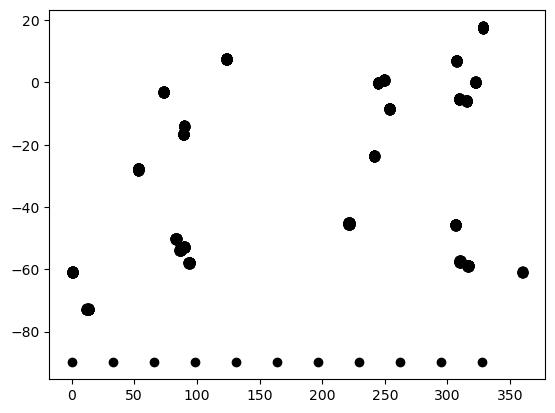

In [14]:
plt.plot(np.degrees(obs['RA']), np.degrees(obs['dec']), 'ko')

In [15]:
file = open('save_test.pkl', 'wb')
pickle.dump(sched, file)
file.close()

In [16]:
from subprocess import Popen
ack = Popen(['ls -lh *.pkl'], shell=True)

-rw-r--r--  1 yoachim  staff   3.4M Sep 21 16:46 save_test.pkl


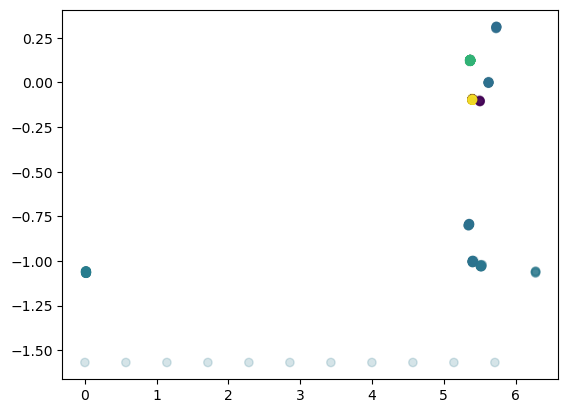

In [19]:
plt.scatter(completed_obs['RA'], completed_obs['dec'], c=completed_obs['mjd'], alpha=0.1)